# Homework 3: Robotic Control of an Elastic Beam

**MAE 263F - Mechanics of Flexible Structures & Soft Robots**

## Problem Description
This notebook implements a control system for a slender elastic aluminum beam manipulated by a planar robotic end-effector. The beam is:
- Clamped at the left end (fixed at origin)
- Controlled by a robot at the right end (position and orientation)
- Required to track a prescribed quarter-circle trajectory with its middle node

**Key Features**:
- Beam: L = 1 m aluminum circular tube
- Discretization: 21 nodes with mass-spring model
- Target: Middle node follows quarter-circle path over 1000 seconds
- Control: Simple feedback controller using for loops

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Helper Functions

In [97]:
def crossMat(a):
    """
    Returns the cross product matrix of vector 'a'.
    
    Parameters:
    a : np.ndarray
        A 3-element array representing a vector.
    
    Returns:
    A : np.ndarray
        The cross product matrix corresponding to vector 'a'.
    """
    A = np.array([[0, -a[2], a[1]],
                  [a[2], 0, -a[0]],
                  [-a[1], a[0], 0]])
    return A

## Elastic Energy Functions: Bending

In [98]:
def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the derivative of bending energy E_k^b with respect to
    x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.
    """
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])
    
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])
    
    kappaBar = curvature0
    gradKappa = np.zeros(6)
    
    ee = node1 - node0
    ef = node2 - node1
    
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)
    
    te = ee / norm_e
    tf = ef / norm_f
    
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))
    
    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi
    
    kappa1 = kb[2]
    
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))
    
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]
    
    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k
    
    return dF

In [99]:
def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the Hessian (second derivative) of bending energy E_k^b.
    """
    node0 = np.array([xkm1, ykm1, 0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])
    
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])
    
    kappaBar = curvature0
    gradKappa = np.zeros(6)
    
    ee = node1 - node0
    ef = node2 - node1
    
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)
    
    te = ee / norm_e
    tf = ef / norm_f
    
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))
    
    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi
    
    kappa1 = kb[2]
    
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))
    
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]
    
    DDkappa1 = np.zeros((6, 6))
    
    norm2_e = norm_e**2
    norm2_f = norm_f**2
    
    Id3 = np.eye(3)
    
    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2e = np.outer(kb, m2e)
    
    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e - \
                  kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) + \
                  (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)
    
    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T
    kb_o_d2f = np.outer(kb, m2f)
    
    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f - \
                  kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) + \
                  (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)
    
    D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                  + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + \
                  tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DfDe = D2kappa1DeDf.T
    
    DDkappa1[0:2, 0:2] = D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]
    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] = D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] - \
                         D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
    DDkappa1[2:4, 4:6] = D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] = D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] = D2kappa1Df2[0:2, 0:2]
    
    dkappa = kappa1 - kappaBar
    dJ = 1.0 / l_k * EI * np.outer(gradKappa, gradKappa)
    dJ += 1.0 / l_k * dkappa * EI * DDkappa1
    
    return dJ

## Elastic Energy Functions: Stretching

In [100]:
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    Calculate the gradient of the stretching energy.
    """
    F = np.zeros(4)
    F[0] = -(1.0 - np.sqrt((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0) / l_k) * \
           ((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0)**(-0.5) / l_k * (-2.0 * xkp1 + 2.0 * xk)
    F[1] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * \
           ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (-0.2e1 * ykp1 + 0.2e1 * yk)
    F[2] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * \
           ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * xkp1 - 0.2e1 * xk)
    F[3] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * \
           ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * ykp1 - 0.2e1 * yk)
    
    F = 0.5 * EA * l_k * F
    return F

In [101]:
def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    Returns the 4x4 Hessian of the stretching energy E_k^s.
    """
    J = np.zeros((4, 4))
    
    J11 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 + \
          (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 - \
          0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    
    J12 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + \
          (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (-2 * ykp1 + 2 * yk) / 0.2e1
    
    J13 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + \
          (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * xkp1 - 2 * xk) / 0.2e1 + \
          0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    
    J14 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + \
          (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    
    J22 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 + \
          (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 - \
          0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    
    J23 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + \
          (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * xkp1 - 2 * xk) / 0.2e1
    
    J24 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + \
          (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * ykp1 - 2 * yk) / 0.2e1 + \
          0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    
    J33 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) ** 2) / 0.2e1 + \
          (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * xkp1 - 2 * xk) ** 2) / 0.2e1 - \
          0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    
    J34 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (2 * xkp1 - 2 * xk)) / 0.2e1 + \
          (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (2 * xkp1 - 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    
    J44 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) ** 2) / 0.2e1 + \
          (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * ykp1 - 2 * yk) ** 2) / 0.2e1 - \
          0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * \
          (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    
    J = np.array([[J11, J12, J13, J14],
                  [J12, J22, J23, J24],
                  [J13, J23, J33, J34],
                  [J14, J24, J34, J44]])
    
    J *= 0.5 * EA * l_k
    return J

## Assemble Force Vector and Stiffness Matrix

In [102]:
def getFs(q, EA, deltaL):
    """
    Compute stretching force and Jacobian.
    """
    ndof = q.size
    N = ndof // 2
    
    Fs = np.zeros(ndof)
    Js = np.zeros((ndof, ndof))
    
    for k in range(0, N-1):
        xkm1 = q[2*k]
        ykm1 = q[2*k+1]
        xk = q[2*k+2]
        yk = q[2*k+3]
        ind = np.arange(2*k, 2*k+4)
        
        gradEnergy = gradEs(xkm1, ykm1, xk, yk, deltaL, EA)
        hessEnergy = hessEs(xkm1, ykm1, xk, yk, deltaL, EA)
        
        Fs[ind] -= gradEnergy
        Js[np.ix_(ind, ind)] -= hessEnergy
    
    return Fs, Js

In [103]:
def getFb(q, EI, deltaL):
    """
    Compute bending force and Jacobian.
    """
    ndof = q.size
    N = ndof // 2
    
    Fb = np.zeros(ndof)
    Jb = np.zeros((ndof, ndof))
    
    for k in range(1, N-1):
        xkm1 = q[2*k-2]
        ykm1 = q[2*k-1]
        xk = q[2*k]
        yk = q[2*k+1]
        xkp1 = q[2*k+2]
        ykp1 = q[2*k+3]
        ind = np.arange(2*k-2, 2*k+4)
        
        gradEnergy = gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)
        hessEnergy = hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)
        
        Fb[ind] -= gradEnergy
        Jb[np.ix_(ind, ind)] -= hessEnergy
    
    return Fb, Jb

## Time Integration (Newton-Raphson Solver)

In [104]:
def objfun(q_old, u_old, dt, tol, maximum_iter,
           m, mMat, EI, EA, W, C, deltaL, free_index):
    """
    Implicit time stepping solver using Newton-Raphson method.
    """
    q_new = q_old.copy()
    
    iter_count = 0
    error = tol * 10
    flag = 1
    
    while error > tol:
        # Inertia
        F_inertia = m/dt * ((q_new - q_old) / dt - u_old)
        J_inertia = mMat / dt ** 2
        
        # Elastic forces
        Fs, Js = getFs(q_new, EA, deltaL)
        Fb, Jb = getFb(q_new, EI, deltaL)
        F_elastic = Fs + Fb
        J_elastic = Js + Jb
        
        # Viscous force
        Fv = - C @ ( q_new - q_old ) / dt
        Jv = - C / dt
        
        # Equations of motion
        f = F_inertia - F_elastic - Fv - W
        J = J_inertia - J_elastic - Jv
        
        f_free = f[free_index]
        J_free = J[np.ix_(free_index, free_index)]
        
        # Newton's update
        dq_free = np.linalg.solve(J_free, f_free)
        q_new[free_index] = q_new[free_index] - dq_free
        
        # Check error
        error = np.linalg.norm(f_free)
        
        iter_count += 1
        if iter_count > maximum_iter:
            flag = -1
            print("Maximum number of iterations reached.")
            return q_new, flag
    
    return q_new, flag

In [105]:
def target_trajectory(t, RodLength):
    """
    Compute target position for middle node at time t.
    Quarter-circle trajectory.
    
    Returns: (x_star, y_star)
    """
    x_star = RodLength / 2 * np.cos(np.pi / 2 * t / 1000)
    y_star = -RodLength / 2 * np.sin(np.pi / 2 * t / 1000)
    return x_star, y_star

In [106]:
def control_law(q_current, u_current, t, xc_current, yc_current, theta_c_current,
                midNode, nv, dt, RodLength):
    """
    Simple feedback control using for loops.
    
    Strategy: Measure the error in middle node position and incrementally
    adjust the robot end-effector to reduce that error.
    
    Returns:
        xc_new, yc_new, theta_c_new: updated control commands
    """
    
    # Step 1: Get desired middle node position
    x_target, y_target = target_trajectory(t, RodLength)
    
    # Step 2: Get current middle node position
    x_mid = q_current[2*(midNode-1)]
    y_mid = q_current[2*(midNode-1) + 1]
    
    # Step 3: Calculate error
    error_x = x_target - x_mid
    error_y = y_target - y_mid
    
    # Step 4: Start with current control values
    xc_new = xc_current
    yc_new = yc_current
    theta_c_new = theta_c_current
    
    # Step 5: Apply corrections using a simple for loop
    gain = 10.0  # Control gain
    num_steps = 5  # Number of correction steps
    
    for step in range(num_steps):
        # Add a portion of the error to the control
        delta_x = gain * error_x / num_steps
        delta_y = gain * error_y / num_steps
        
        xc_new = xc_new + delta_x * dt
        yc_new = yc_new + delta_y * dt
    
    # Step 6: Update angle
    if nv >= 2:
        # Get position of second-to-last node
        x_second_last = q_current[2*(nv-2)]
        y_second_last = q_current[2*(nv-2) + 1]
        
        # Calculate current beam angle at the end
        dx = xc_current - x_second_last
        dy = yc_current - y_second_last
        current_angle = np.arctan2(dy, dx)
        
        # Desired angle points toward the target
        desired_angle = np.arctan2(y_target, x_target)
        
        # Gradually adjust angle
        angle_gain = 0.5
        theta_c_new = current_angle + angle_gain * (desired_angle - current_angle) * dt
    else:
        theta_c_new = np.arctan2(y_target, x_target)
    
    # Step 7: Add gravity compensation
    sag_per_segment = 0.01
    total_sag = 0.0
    
    for segment in range(midNode, nv):
        total_sag = total_sag + sag_per_segment
    
    yc_new = yc_new + total_sag
    
    return xc_new, yc_new, theta_c_new

In [107]:
# Physical parameters for HW3: Aluminum tube under robotic control
nv = 19  # number of nodes
ndof = 2 * nv
midNode = (nv + 1) // 2  # Middle node index

# Time step
dt = 0.1  # second

# Rod length
RodLength = 1.0  # meter

# Discrete length
deltaL = RodLength / (nv - 1)

# Tube geometry
R_outer = 0.013  # outer radius in meters
R_inner = 0.011  # inner radius in meters

# Material properties (Aluminum)
Y = 70e9  # Young's modulus in Pa
rho_metal = 2700  # Density in kg/m^3

# Cross-sectional properties
A = np.pi * (R_outer**2 - R_inner**2)
I = np.pi / 4 * (R_outer**4 - R_inner**4)

# Gravity
g = 9.81  # m/s^2

# Stiffness
EI = Y * I
EA = Y * A

# Tolerance
tol = EI / RodLength**2 * 1e-3

# Maximum iterations
maximum_iter = 100

# Total time
totalTime = 1000  # seconds

# Plotting
plotStep = 50

print(f"Number of nodes: {nv}")
print(f"Middle node: {midNode}")
print(f"EI = {EI:.6e} N·m²")
print(f"EA = {EA:.6e} N")

Number of nodes: 19
Middle node: 10
EI = 7.652920e+02 N·m²
EA = 1.055575e+07 N


In [108]:
# Initial geometry - horizontal beam
nodes = np.zeros((nv, 2))
for c in range(nv):
    nodes[c, 0] = c * deltaL
    nodes[c, 1] = 0.0

# Mass vector
m = np.zeros(2 * nv)
mass_per_node = rho_metal * A * RodLength / (nv - 1)
for k in range(0, nv):
    m[2*k] = mass_per_node
    m[2*k + 1] = mass_per_node
mMat = np.diag(m)

# Gravity force
W = np.zeros(2 * nv)
for k in range(0, nv):
    W[2*k] = 0.0
    W[2*k+1] = -mass_per_node * g

# No viscous damping
C = np.zeros((2 * nv, 2 * nv))

# Initial configuration
q0 = np.zeros(2 * nv)
for c in range(nv):
    q0[2*c] = nodes[c, 0]
    q0[2*c+1] = nodes[c, 1]

u0 = np.zeros(2 * nv)

# Initial control state
xc = RodLength
yc = 0.0
theta_c = 0.0

# Boundary conditions
all_DOFs = np.arange(ndof)
fixed_index = np.array([0, 1, 2*(nv-2), 2*(nv-2)+1, 2*(nv-1), 2*(nv-1)+1])
free_index = np.setdiff1d(all_DOFs, fixed_index)

print(f"Mass per node: {mass_per_node:.6f} kg")
print(f"Total beam mass: {mass_per_node * nv:.6f} kg")

Mass per node: 0.022619 kg
Total beam mass: 0.429770 kg


In [109]:
# Number of steps
Nsteps = round(totalTime / dt)

ctime = 0  # Current time

# Storage arrays
all_pos = np.zeros(Nsteps)
all_vel = np.zeros(Nsteps)
mid_angle = np.zeros(Nsteps)
all_xc = np.zeros(Nsteps)
all_yc = np.zeros(Nsteps)
all_theta_c = np.zeros(Nsteps)
all_error_x = np.zeros(Nsteps)
all_error_y = np.zeros(Nsteps)

# Snapshot storage
snapshot_configs = []
snapshot_time_indices = []

# Initial values
all_pos[0] = q0[2*midNode-1]
all_vel[0] = 0
mid_angle[0] = 0
all_xc[0] = xc
all_yc[0] = yc
all_theta_c[0] = theta_c

# Save initial configuration
snapshot_configs.append(q0.copy())
snapshot_time_indices.append(0)

print("Starting simulation...")
print(f"Total time steps: {Nsteps}")

# Time stepping loop
for timeStep in range(1, Nsteps):
    
    # Update control
    xc, yc, theta_c = control_law(q0, u0, ctime, xc, yc, theta_c,
                                   midNode, nv, dt, RodLength)
    
    # Apply boundary conditions
    q0[0] = 0.0
    q0[1] = 0.0
    q0[2*(nv-1)] = xc
    q0[2*(nv-1)+1] = yc
    q0[2*(nv-2)] = xc - deltaL * np.cos(theta_c)
    q0[2*(nv-2)+1] = yc - deltaL * np.sin(theta_c)
    
    # Solve for new configuration
    q_new, error = objfun(q0, u0, dt, tol, maximum_iter, m, mMat, EI, EA, W, C,
                          deltaL, free_index)
    if error < 0:
        print(f'Could not converge at time step {timeStep}')
        break
    
    # Enforce boundary conditions on q_new
    q_new[0] = 0.0
    q_new[1] = 0.0
    q_new[2*(nv-1)] = xc
    q_new[2*(nv-1)+1] = yc
    q_new[2*(nv-2)] = xc - deltaL * np.cos(theta_c)
    q_new[2*(nv-2)+1] = yc - deltaL * np.sin(theta_c)
    
    u_new = (q_new - q0) / dt
    
    ctime += dt
    
    # Save data
    all_pos[timeStep] = q_new[2*midNode-1]
    all_vel[timeStep] = u_new[2*midNode-1]
    
    # Calculate turning angle
    if midNode > 1 and midNode < nv:
        vec1 = np.array([q_new[2*(midNode-1)-2], q_new[2*(midNode-1)-1], 0]) - \
               np.array([q_new[2*(midNode-2)], q_new[2*(midNode-2)+1], 0])
        vec2 = np.array([q_new[2*midNode], q_new[2*midNode+1], 0]) - \
               np.array([q_new[2*(midNode-1)], q_new[2*(midNode-1)+1], 0])
        cross_prod = np.cross(vec1, vec2)
        dot_prod = np.dot(vec1, vec2)
        mid_angle[timeStep] = np.degrees(np.arctan2(np.linalg.norm(cross_prod), dot_prod))
    
    # Save control inputs
    all_xc[timeStep] = xc
    all_yc[timeStep] = yc
    all_theta_c[timeStep] = theta_c
    
    # Save tracking error
    x_star, y_star = target_trajectory(ctime, RodLength)
    all_error_x[timeStep] = x_star - q_new[2*(midNode-1)]
    all_error_y[timeStep] = y_star - q_new[2*(midNode-1)+1]
    
    # Save snapshots
    if timeStep % (Nsteps // 20) == 0:
        snapshot_configs.append(q_new.copy())
        snapshot_time_indices.append(ctime)
    
    q0 = q_new.copy()
    u0 = u_new.copy()
    

Starting simulation...
Total time steps: 10000


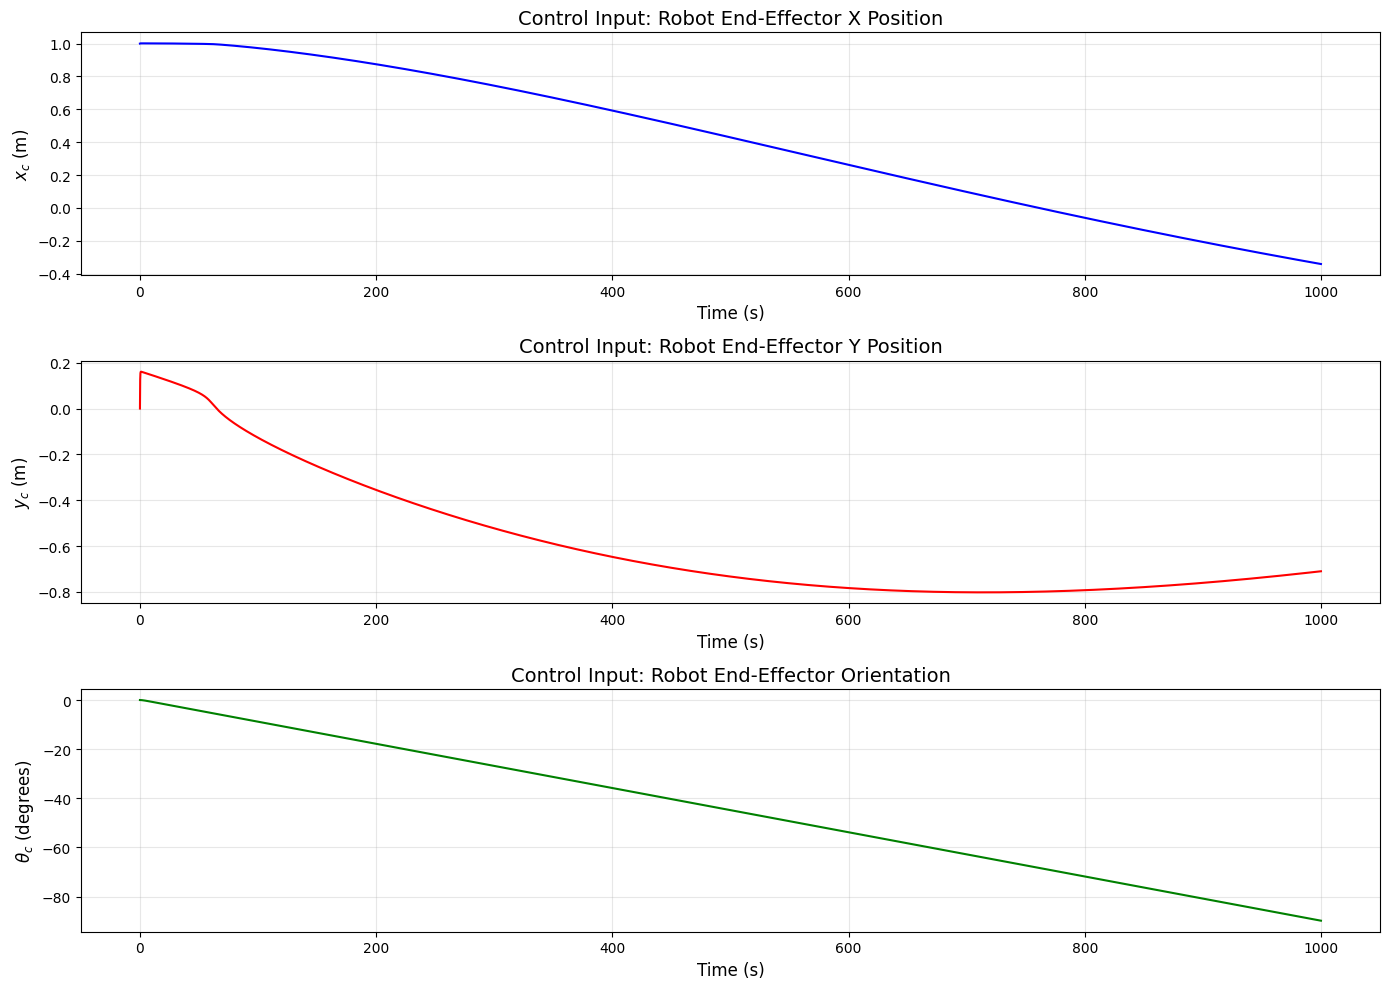

In [110]:
t_arr = np.linspace(0, totalTime, Nsteps)

plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(t_arr, all_xc, 'b-', linewidth=1.5)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('$x_c$ (m)', fontsize=12)
plt.title('Control Input: Robot End-Effector X Position', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(t_arr, all_yc, 'r-', linewidth=1.5)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('$y_c$ (m)', fontsize=12)
plt.title('Control Input: Robot End-Effector Y Position', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(t_arr, np.degrees(all_theta_c), 'g-', linewidth=1.5)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('$\\theta_c$ (degrees)', fontsize=12)
plt.title('Control Input: Robot End-Effector Orientation', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


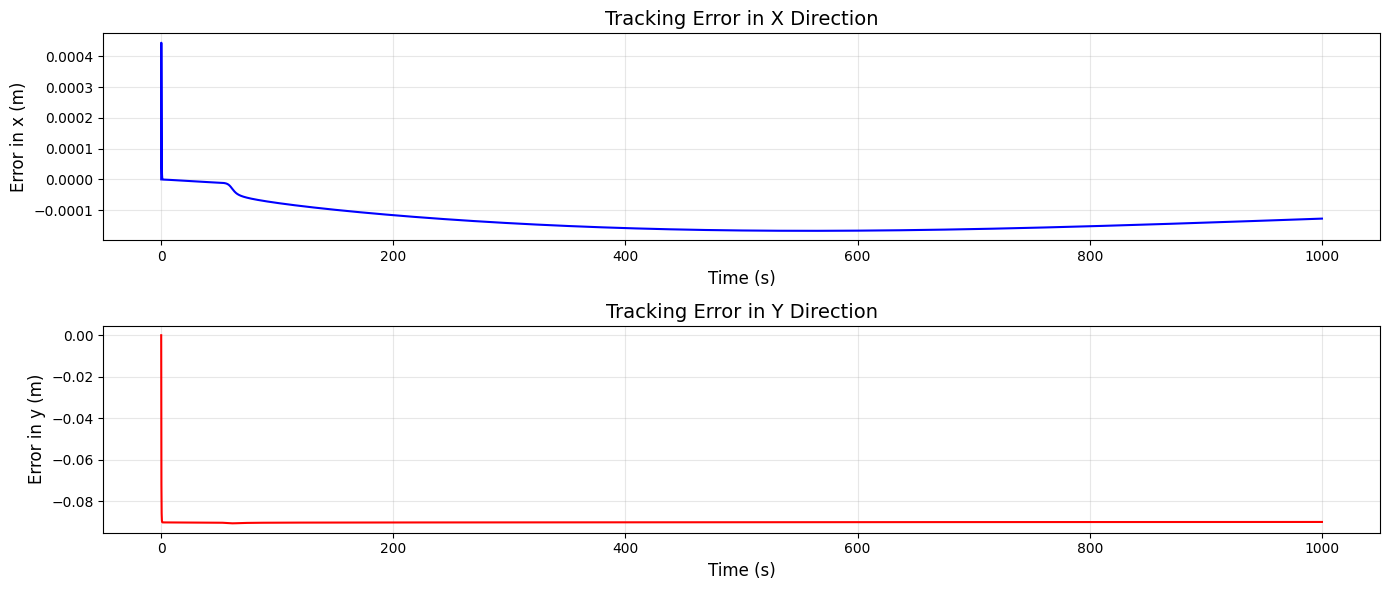

In [111]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(t_arr, all_error_x, 'b-', linewidth=1.5)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Error in x (m)', fontsize=12)
plt.title('Tracking Error in X Direction', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(t_arr, all_error_y, 'r-', linewidth=1.5)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Error in y (m)', fontsize=12)
plt.title('Tracking Error in Y Direction', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


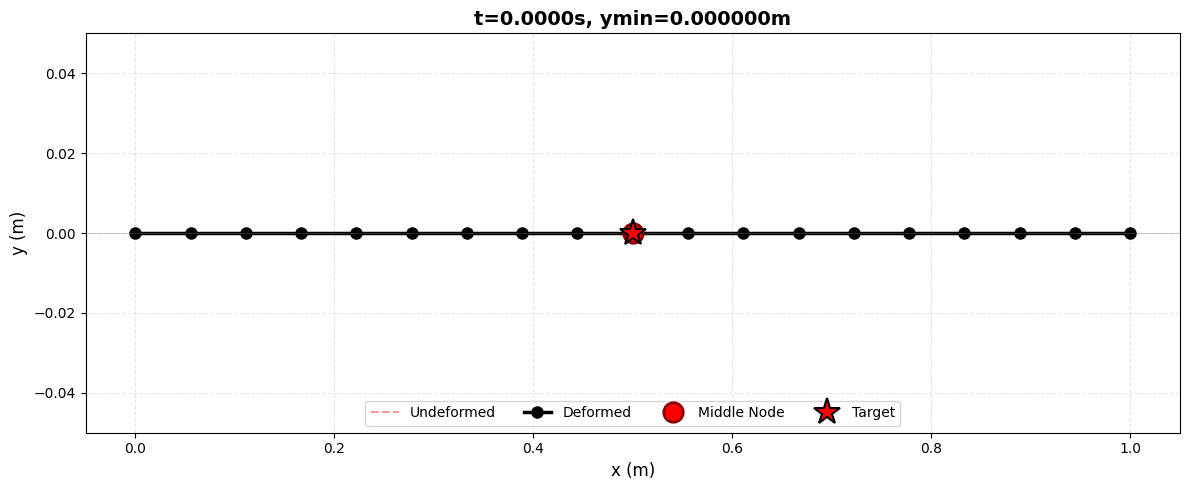

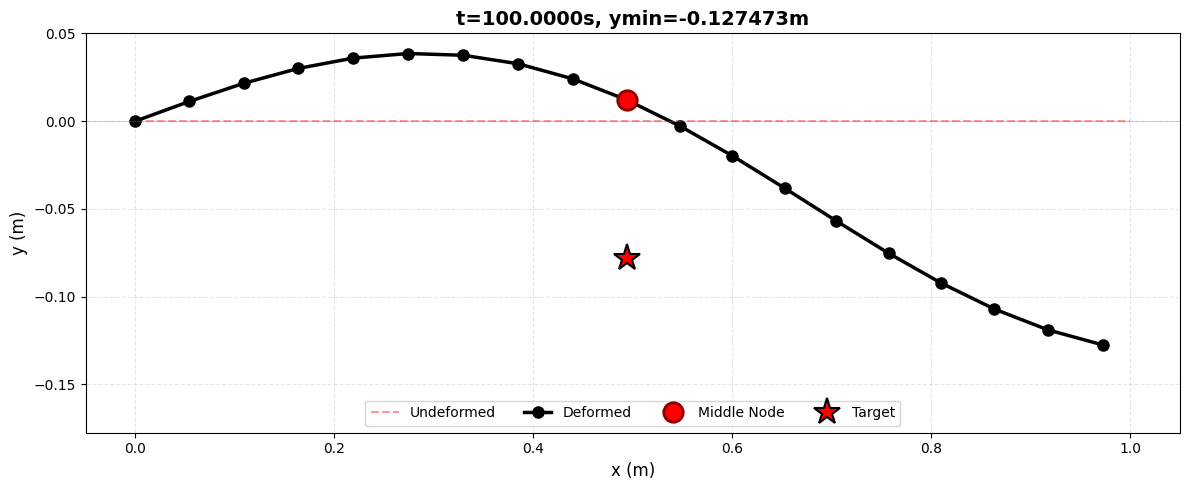

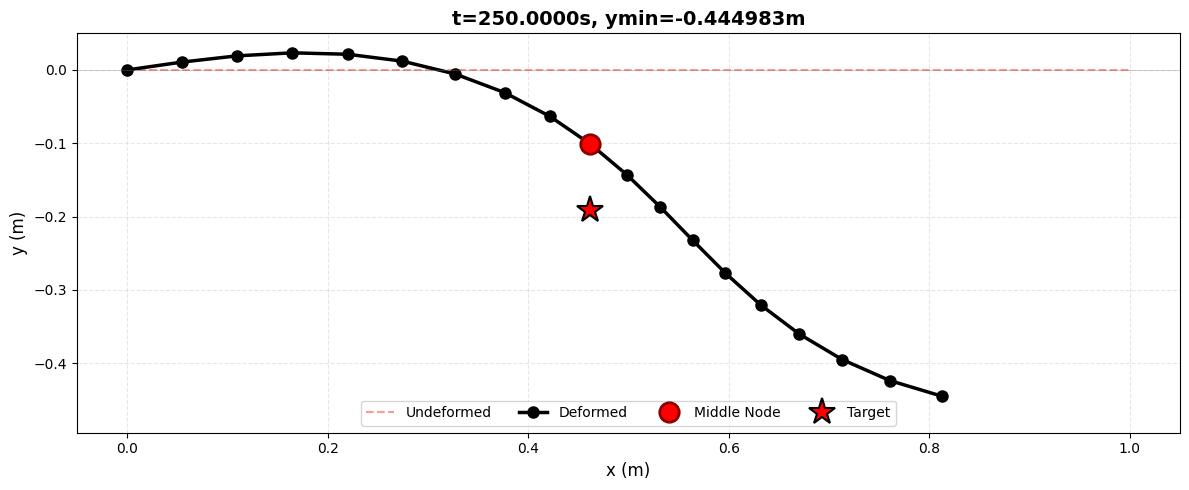

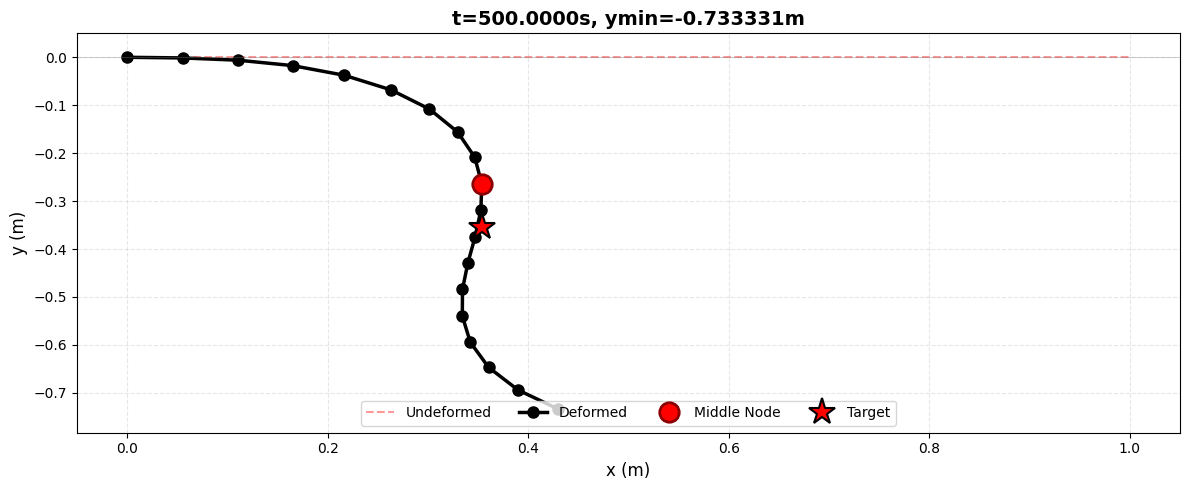

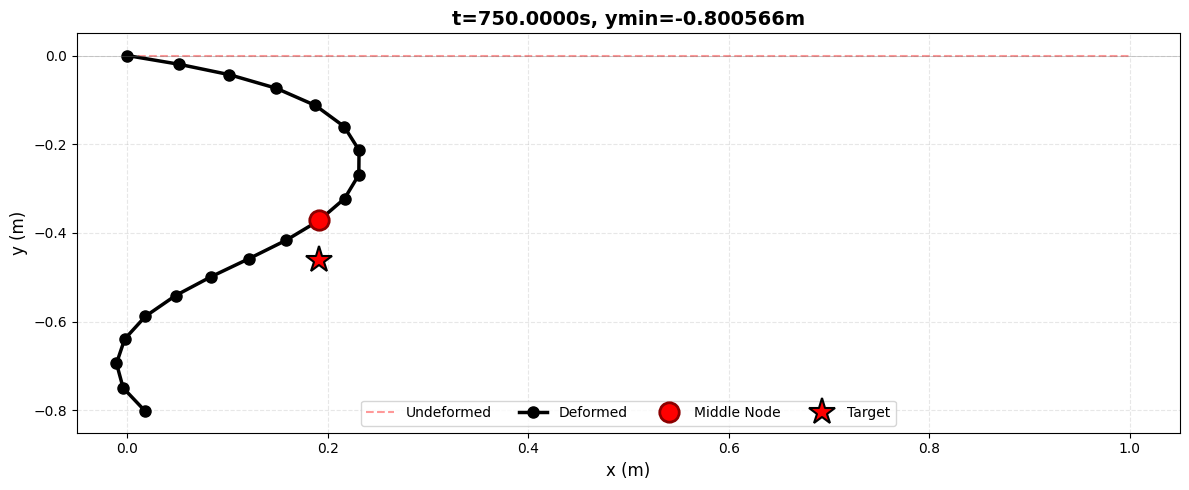

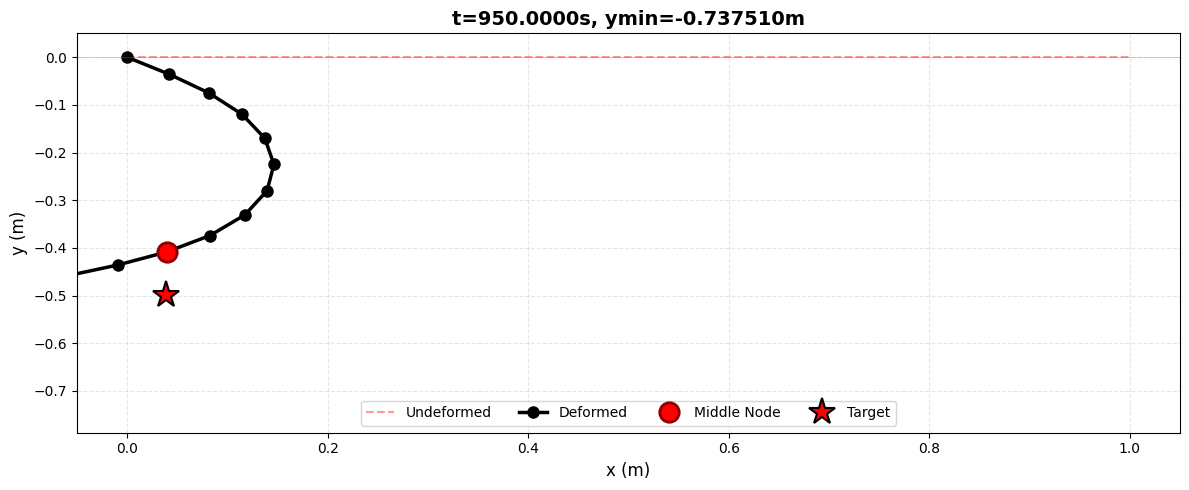

In [112]:
# Create individual plots showing beam deformation
time_instants_to_plot = [0, 100, 250, 500, 750, 1000]

for t_desired in time_instants_to_plot:
    # Find closest snapshot
    closest_idx = np.argmin([abs(t - t_desired) for t in snapshot_time_indices])
    
    if closest_idx < len(snapshot_configs):
        q_snap = snapshot_configs[closest_idx]
        t_snap = snapshot_time_indices[closest_idx]
        
        x_nodes = q_snap[::2]
        y_nodes = q_snap[1::2]
        y_min = np.min(y_nodes)
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        
        # Undeformed
        x_undeformed = np.linspace(0, RodLength, nv)
        y_undeformed = np.zeros(nv)
        ax.plot(x_undeformed, y_undeformed, 'r--', linewidth=1.5, 
                alpha=0.4, label='Undeformed')
        
        # Deformed
        ax.plot(x_nodes, y_nodes, 'ko-', linewidth=2.5, markersize=8, 
                markerfacecolor='black', label='Deformed')
        
        # Middle node
        ax.plot(x_nodes[midNode-1], y_nodes[midNode-1], 'ro', 
                markersize=14, markeredgecolor='darkred', markeredgewidth=2,
                label=f'Middle Node', zorder=5)
        
        # Target
        x_target, y_target = target_trajectory(t_snap, RodLength)
        ax.plot(x_target, y_target, 'r*', markersize=20, 
                label='Target', zorder=5, markeredgecolor='black', 
                markeredgewidth=1.5)
        
        ax.set_title(f't={t_snap:.4f}s, ymin={y_min:.6f}m', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('x (m)', fontsize=12)
        ax.set_ylabel('y (m)', fontsize=12)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='lower center', fontsize=10, ncol=4)
        ax.set_xlim([-0.05, RodLength + 0.05])
        ax.set_ylim([y_min - 0.05, 0.05])
        ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        